# Verification and Hyperparameters

## 1. Model evaluation

### 1.01 Time-delay neural net predictions

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import xarray as xr

import sys
sys.path.append('../../')
from python.aux.plot import plot_recurrent
from python.aux.utils import xr_to_datetime

In [159]:
# load the truth (reanalysis)
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
dis = glofas['dis']

lat, lon = 48.35, 13.95  # the point where predictions are made
truth = dis.interp(latitude=lat, longitude=lon)
truth

<xarray.DataArray 'dis' (time: 5478)>
array([798.361572, 792.207703, 796.706116, ..., 783.30896 , 782.144958,
       778.828003])
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude   float64 48.35
    longitude  float64 13.95
Attributes:
    long_name:  discharge
    units:      m3/s

In [3]:
def open_prediction(path):
    """Convenience function"""
    return xr.open_dataset(path).to_array().squeeze().drop(['variable', 'name'])

In [4]:
# load predictions
model_dir = '../../models/'

model_name = 'tdnn-catchment_mean-differences2'

In [5]:
validation = open_prediction(model_dir+model_name+'/validation.nc')
test = open_prediction(model_dir+model_name+'/test.nc')

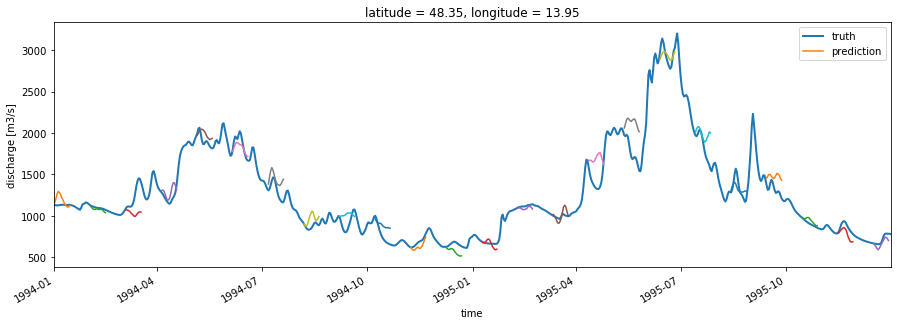

In [6]:
test_time = slice('1994', '1995')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=truth.sel(time=test_time), 
                   prediction=test, each_N=31)

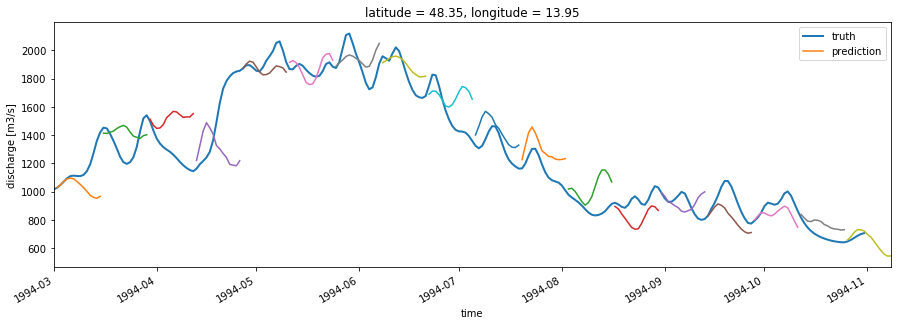

In [11]:
time=slice('1994-03', '1994-10')

fix, ax = plt.subplots(figsize=(15,5))
plot_recurrent(ax, truth=truth.sel(time=time),
                   prediction=test.sel(init_time=time), each_N=14)

## Quantitative Verification
### Bias, RMSE, Nash-Sutcliffe-Efficiency

$$
Bias = \sum_{n=1}^N   | \hat{y}_n - y_n |
$$

$$
RMSE =\sqrt{ \sum_{n=1}^N  (\hat{y}_n - y_n)^2 }
$$


$$
NSE = 1- \sum_{n=1}^N  \frac{(\hat{y}_n - y_n)^2}{(y_n - \overline{y})^2} 
$$

In [189]:
def RMSE(difference):
    return float(np.sqrt(np.mean(difference**2)))

def ME(difference):
    return float(np.mean(difference))

def NSE(difference, observed_discharge):
    squarediff = np.dot(difference, difference)
    obs_dis_prime = observed_discharge - np.mean(observed_discharge)
    return float(1-squarediff/np.dot(obs_dis_prime, obs_dis_prime))

In [205]:

def verify(prediction, truth, test_predict_mean=False):
    index, rmse, bias, nse = [], [], [], []

    fcst_days = prediction.forecast_day.values
    for day in fcst_days:
        pred_day = prediction.sel(forecast_day=day)

        # for subtracting the correct truth value, we need the a time dimension
        # stating the validity datetime
        pred_day.coords['time'] = pred_day.init_time + np.timedelta64(day, 'D')

        # new index = time (valid time)
        pred_day = pred_day.set_index(dict(time='init_time')
                          ).rename({'init_time': 'time'})

        truth_day = truth.sel(time=pred_day.time)
        
        if test_predict_mean:
            delta = np.mean(truth_day) - truth_day  # test case
        else:
            delta = pred_day - truth_day

        index.append(day)
        rmse.append(RMSE(delta))
        bias.append(ME(delta))
        nse.append(NSE(delta, truth_day))

    df = pd.DataFrame(index=index, data=dict(RMSE=rmse, Bias=bias, NSE=nse))
    df.index.name = 'forecast_day'
    return df


d = verify(test, truth, test_predict_mean=True)
print('Test-case (predict the mean discharge): \n', d)


Test-case (predict the mean discharge): 
                     RMSE          Bias  NSE
forecast_day                               
1             542.667425  9.145757e-14  0.0
2             542.667425  9.145757e-14  0.0
3             542.667425  9.145757e-14  0.0
4             542.667425  9.145757e-14  0.0
5             542.667425  9.145757e-14  0.0
6             542.667425  9.145757e-14  0.0
7             542.667425  9.145757e-14  0.0
8             542.667425  9.145757e-14  0.0
9             542.667425  9.145757e-14  0.0
10            542.667425  9.145757e-14  0.0
11            542.667425  9.145757e-14  0.0
12            542.667425  9.145757e-14  0.0
13            542.667425  9.145757e-14  0.0
14            542.667425  9.145757e-14  0.0


Text(0, 0.5, 'discharge [m^3/s]')

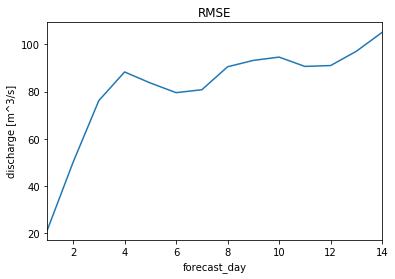

In [210]:
d = verify(test, truth)
d.RMSE.plot(title='RMSE')
plt.ylabel('discharge [m^3/s]')

Text(0, 0.5, 'discharge [m^3/s]')

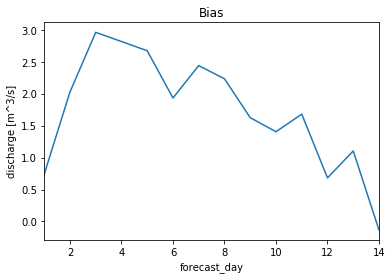

In [211]:
d.Bias.plot(title='Bias')
plt.ylabel('discharge [m^3/s]')

Text(0, 0.5, 'nondimensional')

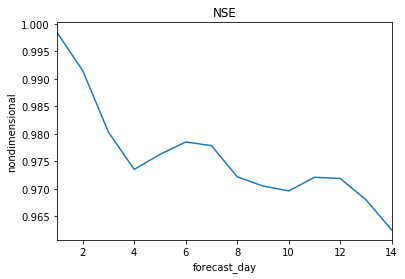

In [212]:
d.NSE.plot(title='NSE')
plt.ylabel('nondimensional')

## 2. Hyperparameters

### 2.01 Time-delay neural net

- Architecture (hidden layers, number of nodes)

description




### 2.02 LSTM network

- Architecture (stacked layers)

description

- Number of forecast days


- Regularization (dropout)

description